In [ ]:
# Note on nov 23rd
# I somehow cannot import all tensorflow packages in jupyter but I manage to do it on my spyder editor.
# The previous y (absolute damage loss) has been changed into new y (relative damage loss to GDP),
# thus this is a new dataset!

# Till now, the performance according to MSE and MAE is best NN so far > GP > Linear regression as we expected
# I am still waiting for the training of NN for shapley value and coefficient comparison.

In [5]:
########### Import packages 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib import rc
rc('text', usetex=False)
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
#!pip install shap
import shap
#from sklearn.preprocessing import MinMaxScaler
#!pip uninstall keras-nightly
import re
#from bayes_opt import BayesianOptimization
import pickle
from sklearn.linear_model import LinearRegression
print('packages imported.')

packages imported.


In [12]:
########### Functions
def R_squared(x, y, name = 'R_squared'):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den
def my_nn(lr, neuron_num, l1, l2, verbose, epoch):
    tf.random.set_seed(42)
    model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(100, 
                          activation='LeakyReLU',
    activity_regularizer = tf.keras.regularizers.L1L2(l1, l2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation = 'tanh'),
    tf.keras.layers.Dense(5, activation = 'sigmoid'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(neuron_num, activation='LeakyReLU',
    activity_regularizer = tf.keras.regularizers.L1L2(l1, l2)),
    ])
    #model_4.compile(loss=tf.keras.losses.mae,
    #optimizer=tf.keras.optimizers.Adam(),
    #metrics=['mae'])
    
    model_4.compile(loss=tf.keras.losses.mse,
                    #optimizer = tf.keras.optimizers.experimental.Adagrad(learning_rate = 0.001),
                    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics = [R_squared])
    
    history4 = model_4.fit(
        X_train,
        y_train,
        epochs=epoch,
        # Suppress logging.
        verbose=verbose,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2)
    #plot_mse(history4)
    string = "lr{}_num{}_l1{}_l2{}".format(lr, neuron_num, l1, l2)
    string = string.replace('.', '-')
    yhat4 = model_4.predict(X_test)
    #plt.plot(y_test.to_numpy().reshape(-1,1), 'kx')
    #plt.plot(yhat4, 'rx')
    mae = tf.metrics.mean_absolute_error(y_true=y_test, y_pred=yhat4)
    mse = tf.metrics.mean_squared_error(y_true = y_test, y_pred=yhat4)
    print(string)
    print('MAE: {}'.format( np.mean(mae)))
    print('MSE: {}'.format( np.mean(mse)))
    history4.history['test_mae'] = round(np.mean(mae),5)
    history4.history['test_mse'] = round(np.mean(mse),5)
    with open('nn_train_log/{}.pkl'.format(string), 'wb') as handle:
        pickle.dump(history4.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return {'test_mse':np.mean(mse),
            'hp':string}
print('functions loaded.')

functions loaded.


In [8]:
########### Load data/ Train-test split
df = pd.read_csv('data/v29.csv')

X = df[['int_drought',
       'int_earthquake', 'int_extreme_temp',
       'int_flood', 'int_landslide',
       'int_tropical', 'int_unknown_storm', 'int_conv_storm',
        # background variables
        #'mm_fault_density', 'mm_slope',
         # 'mm_road_density',
        # vulnerability variables
        'multi_phdi', 'multi_ppp','single_phdi', 'single_ppp']]
#y = df[['relative_loss']]
y = df[['ln10_relative_loss']]
print('data loaded.')
#q = pd.qcut(df['relative_loss'], 10, labels=[int(i) for i in range(1, 11)])
#scaler = MinMaxScaler()
#scaler.fit(y)
#X_train, X_test, y_train, y_test = train_test_split(X, q.astype(np.float64),
#X_train, X_test, y_train, y_test = train_test_split(X, scaler.transform(y)*10,
#X_train, X_test, y_train, y_test = train_test_split(X, scaler.transform(y)*10,
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state = 4)
print('data splited.')
data_train = X_train.copy()

#data_train['y_train'] = y_train.reshape(-1,1)
data_train['y_train'] = y_train.to_numpy().reshape(-1,1)
# check data
#sns.pairplot(data_train[data_train.columns.to_list()], diag_kind='kde')

data loaded.
data splited.


linear regression on test data MAE:
0.9138298862580184
MSE:
1.3210175538578557


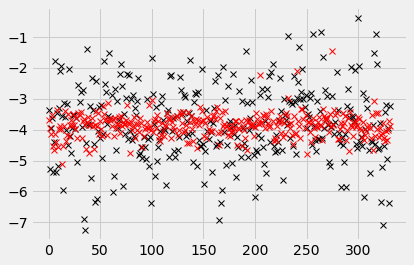

In [11]:
############ linear regression

model = LinearRegression().fit(X_train, y_train)
yhat = model.predict(X_test)
mae = np.sum(np.abs(yhat-y_test.to_numpy().reshape(-1,1)))/y_test.to_numpy().shape[0]
mse = np.sum((yhat-y_test.to_numpy().reshape(-1,1))**2)/y_test.to_numpy().shape[0]
print('linear regression on test data MAE:')
print(np.mean(mae))
print('MSE:')
print(np.mean(mse))
#print(R_squared(y_test.to_numpy().reshape(-1,1), yhat))
plt.plot(y_test.to_numpy().reshape(-1,1), 'kx')
plt.plot(yhat, 'rx')

In [14]:
############# GP regression 
#(Note that I take away 3 variables
# because my other supervisors think they are irrelevant)
import gpflow
from gpflow.utilities import positive, print_summary
# Configure GP regression
k0 = gpflow.kernels.RBF(active_dims=[0])
k1 = gpflow.kernels.RBF(active_dims=[1])
k2 = gpflow.kernels.RBF(active_dims=[2])
k3 = gpflow.kernels.RBF(active_dims=[3])
k4 = gpflow.kernels.RBF(active_dims=[4])
k5 = gpflow.kernels.RBF(active_dims=[5])
k6 = gpflow.kernels.RBF(active_dims=[6])
k7 = gpflow.kernels.RBF(active_dims=[7])
k8 = gpflow.kernels.RBF(active_dims=[8])
k9 = gpflow.kernels.RBF(active_dims=[9])
k10 = gpflow.kernels.RBF(active_dims=[10])
k11 = gpflow.kernels.RBF(active_dims=[11])
#k12 = gpflow.kernels.RBF(active_dims=[12])
#k13 = gpflow.kernels.RBF(active_dims=[13])
#k14 = gpflow.kernels.RBF(active_dims=[14])

X_train_gp = X_train.to_numpy()
#y_train_gp = y_train.to_numpy().reshape(-1,1)
y_train_gp = np.array(y_train).reshape(-1,1)
#k = k0+k1+k2+k3+k4+k5+k6+k7+k8+k9+k10+k11+k12+k13+k14
k = k0+k1+k2+k3+k4+k5+k6+k7+k8+k9+k10+k11

m = gpflow.models.GPR((X_train_gp, y_train_gp), kernel=k)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

mean,var = m.predict_y(X_test.to_numpy())
plt.plot(y_test.to_numpy().reshape(-1,1), "kx", mew = 2)
plt.plot(mean, "rx", mew = 2)

# mae
mae_gp = np.sum(np.abs(mean-y_test.to_numpy().reshape(-1,1)))/y_test.to_numpy().shape[0]
print('MAE:')
print(mae_gp)
# mse
print('MSE:')
mse_gp = np.sum((mean-y_test.to_numpy().reshape(-1,1))**2)/y_test.to_numpy().shape[0]
print(mse_gp)
# r2
#print(R_squared(y_test.to_numpy().reshape(-1,1), mean))



Failed to import TensorFlow. Please note that TensorFlow is not installed by default when you install TensorFlow Probability. This is so that users can decide whether to install the GPU-enabled TensorFlow package. To use TensorFlow Probability, please install the most recent version of TensorFlow, by following instructions at https://tensorflow.org/install.




ModuleNotFoundError: No module named 'tensorflow.compat'

In [13]:
########## Neural network training
#  Iterate over all hyperparameter settings
lr_set = [0.001, 0.005, 0.01, 0.05, 0.1]
neuron_num_set = [5, 15, 50, 100]
l1_set = [0.001, 0.01, 0.1]
l2_set = [0.001, 0.01, 0.1]
best_mse = 99
best_hp = []
for i in range(5):
    for j in range(4):
        for p in range(3):
            for q in range(3):
                result =my_nn(lr_set[i], neuron_num_set[j], l1_set[p], l2_set[q], 
                      verbose =0,
                      epoch = 800)
                new_mse = result['test_mse']
                best_mse = min(new_mse,best_mse)
                if best_mse == new_mse:
                    best_hp = result['hp']

AttributeError: module 'tensorflow' has no attribute 'random'